Import necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import requests
from io import BytesIO

Load and preprocess the image

In [ ]:
def load_image(image_path):
    try:
        headers = {'User-Agent': 'DeepDreamVisualization/1.0 (https://example.com)'}
        response = requests.get(image_path, headers=headers)
        response.raise_for_status()  # Raise an error for bad status codes
        image = Image.open(BytesIO(response.content)).convert('RGB')
        transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize to VGG19 expected input size
            transforms.ToTensor(),  # Convert to tensor
        ])
        return transform(image).unsqueeze(0)
    except (requests.RequestException, UnidentifiedImageError) as e:
        print(f"Error loading image: {e}")
        return None

DeepDream function

Performs Deep Dream by modifying an image to maximize activations at a specific layer.
    
    Args:
        model: Pre-trained VGG19 feature extractor
        image: Input image tensor
        layer: Target layer to enhance
        iterations: Number of optimization steps
        lr: Learning rate for image updates

    Returns:
        Transformed image with enhanced patterns

In [ ]:
def deep_dream(model, image, layer, iterations, lr):
    image = image.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([image], lr=lr)

    for i in range(iterations):
        optimizer.zero_grad()
        x = image
        # Forward pass up to the target layer
        for l, module in enumerate(model):
            x = module(x)
            if l == layer:
                loss = -x.norm()  # Maximize activations
                break
        loss.backward()
        optimizer.step()

        if i % 50 == 0 or i == iterations - 1:
            print(f"Iteration {i}/{iterations}, Loss: {loss.item():.4f}")
    return image.detach()

Visualize original and DeepDream images

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 124MB/s]


Iteration 0/200, Loss: -793.9424
Iteration 50/200, Loss: -20511.6309
Iteration 100/200, Loss: -35916.4805
Iteration 150/200, Loss: -49563.9883
Iteration 199/200, Loss: -62557.4023


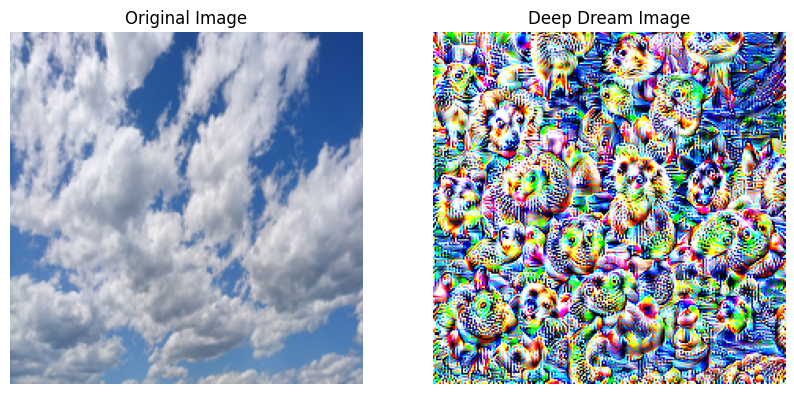

In [ ]:
def visualize_images(original, dreamed):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original.squeeze(0).permute(1, 2, 0))
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    ax[1].imshow(dreamed.squeeze(0).permute(1, 2, 0).clamp(0, 1))
    ax[1].set_title('Deep Dream Image')
    ax[1].axis('off')
    plt.show()

# Load pre-trained VGG19 model and set to evaluation mode
vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.eval()

# Load the input image
image_path = 'https://upload.wikimedia.org/wikipedia/commons/7/73/Cloudy_sky_%2826171935906%29.jpg'
original_image = load_image(image_path)

if original_image is not None:
    # Apply DeepDream algorithm
    layer = 28  # Choose a deep layer to enhance features
    iterations = 200  # Number of iterations for optimization
    lr = 0.01  # Learning rate for updating the image
    dreamed_image = deep_dream(vgg, original_image, layer, iterations, lr)

    # Visualize results
    visualize_images(original_image, dreamed_image)
else:
    print("Failed to load the image.")

Summary of the Code: Deep Dream Visualization

    This code implements Deep Dream, a technique developed by Google to enhance and visualize patterns learned by a Convolutional Neural Network (CNN).
    It does this by modifying an input image to maximize the activation of certain layers in a pre-trained model.

Key Takeaways

    Deep Dream modifies an image to maximize activations in a CNN layer.

    Gradient ascent is used to iteratively enhance features.

    The loss function is defined as the norm of activations, which increases texture emphasis.

    Higher layers in VGG19 highlight more abstract patterns.